In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

In [3]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features
from seghub.convpaint_utils import get_convpaint_features_targets_model, get_convpaint_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_seg_forest, predict_seg_forest_single_image, predict_seg_forest

c:\Users\roman\anaconda3\envs\ilastik\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
shark_vid.shape

(744, 480, 640, 3)

In [6]:
img = shark_vid[0]
# img = img[:,:,0]
img.shape

(480, 640, 3)

In [7]:
v = napari.view_image(img)

In [8]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
v.add_labels(labels)
print(labels.shape)
print(np.sum(labels > 0))

C:\Users\roman\AppData\Local\Temp\ipykernel_7304\2285423432.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))


(480, 640)
2480


## Convpaint

In [9]:
feature_space = get_convpaint_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
feature_space.shape

(480, 640, 384)

In [10]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Convpaint")

<Image layer 'Feature Space Convpaint' at 0x1c8cd4de0a0>

In [11]:
kmeans = get_kmeans_clusters(feature_space, num_clusters=3, img_shape=None)
kmeans.shape

(480, 640)

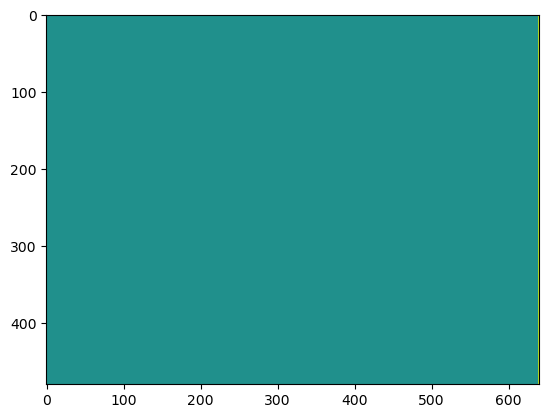

In [12]:
plt.imshow(kmeans)

In [13]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


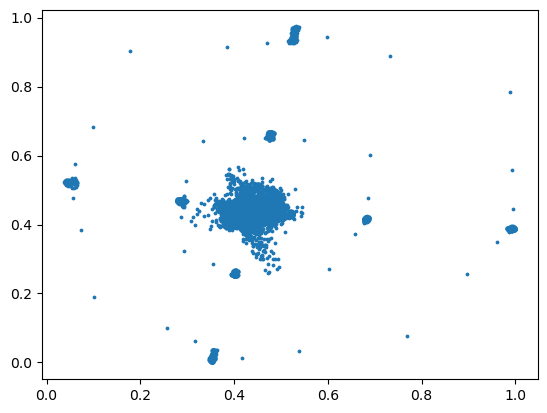

In [14]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [15]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3, img_shape=None)
kmeans_p.shape

(480, 640)

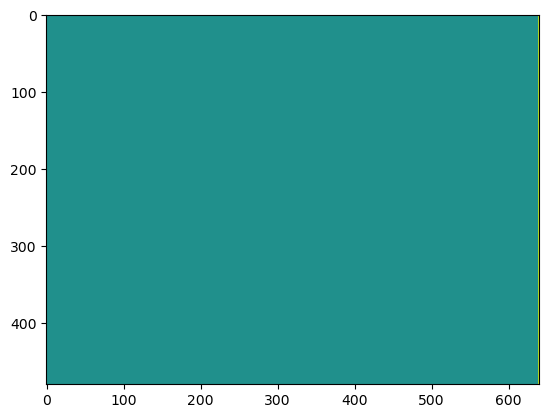

In [16]:
plt.imshow(kmeans_p)

In [17]:
annot_features, targets, model = get_convpaint_features_targets_model(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [18]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(2480, 2)


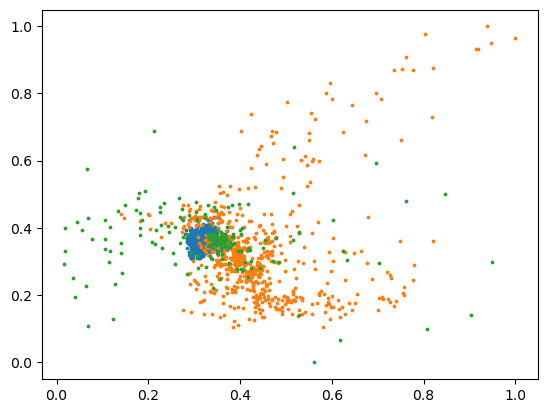

In [19]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [20]:
patch_features = get_dinov2_patch_features(img)
patch_features.shape

C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


(1610, 384)

In [21]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False)
pix_features.shape

(307200, 384)

In [22]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False)
feature_space.shape

(480, 640, 384)

In [23]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space DINOv2")

<Image layer 'Feature Space DINOv2' at 0x1c8c3a348e0>

In [24]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=3, img_shape=None)
kmeans_f.shape

(480, 640)

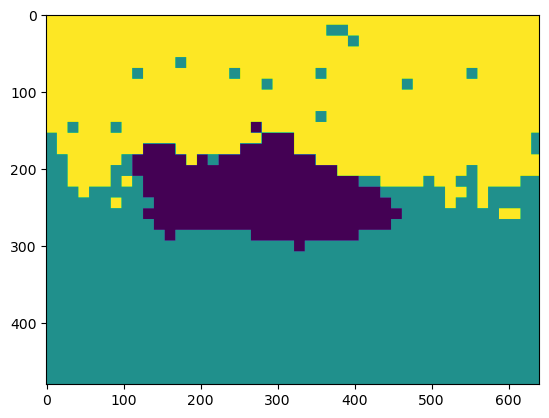

In [25]:
plt.imshow(kmeans_f)

In [26]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


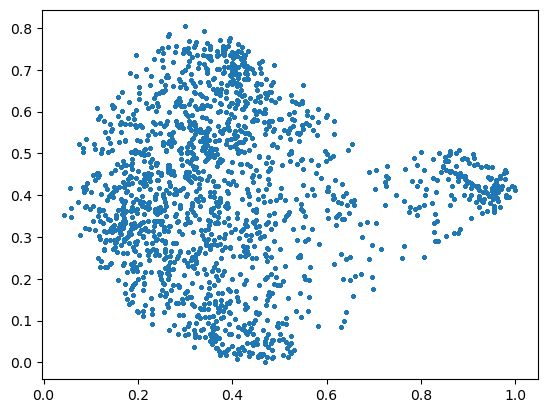

In [27]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [28]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3)
kmeans_p.shape

(480, 640)

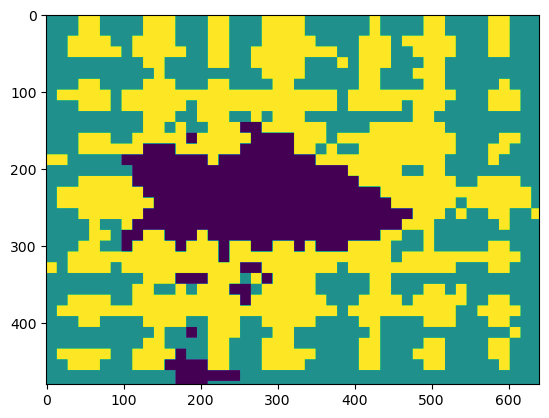

In [29]:
plt.imshow(kmeans_p)

In [30]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [31]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(2480, 2)


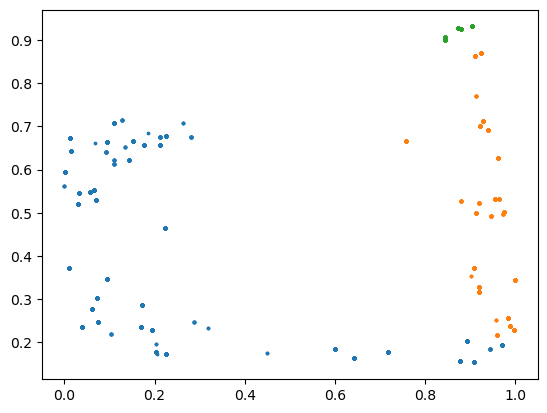

In [32]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [33]:
feature_space = get_ila_feature_space(img)
feature_space.shape

(480, 640, 168)

In [34]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x1c8c451f0d0>

In [35]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=3)
kmeans_f.shape

(480, 640)

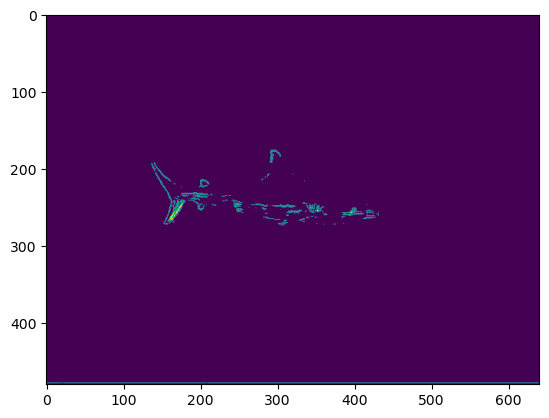

In [36]:
plt.imshow(kmeans_f)

In [37]:
pc = get_pca_features(feature_space, num_components=2)
print(pc.shape)

(480, 640, 2)


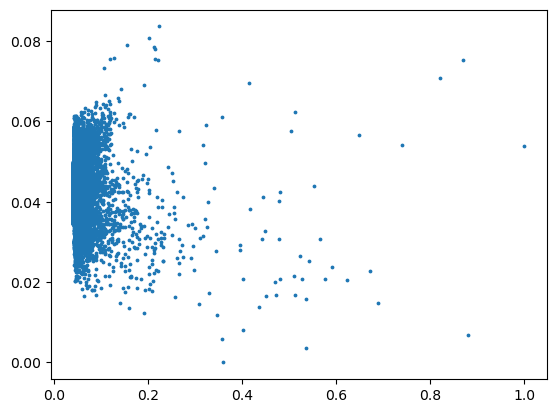

In [38]:
pc_1d = pc.reshape(-1, 2)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [39]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=3)
kmeans_p.shape

(480, 640)

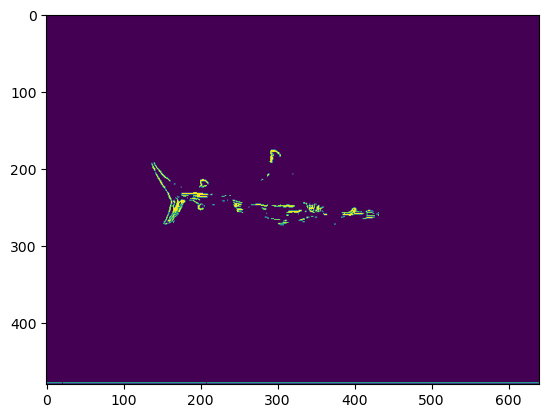

In [40]:
plt.imshow(kmeans_p)

In [41]:
annot_features, targets = get_ila_features_targets(img, labels)

In [42]:
pc_annot = get_pca_features(annot_features, num_components=2)
print(pc_annot.shape)

(2480, 2)


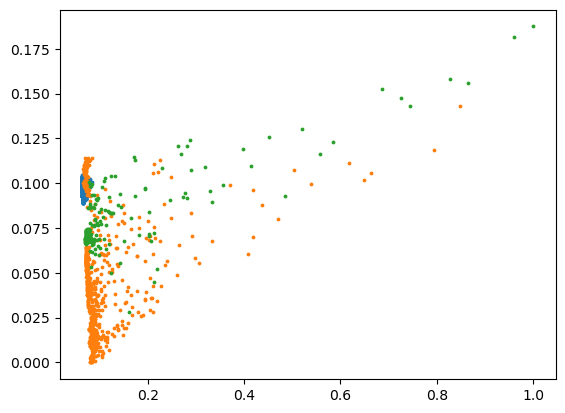

In [43]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [44]:
# features_func_train = get_convpaint_features_targets_model
# features_func_pred = get_convpaint_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_features_targets
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc": 0}
# features_func_train = get_ila_features_targets
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [45]:

rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [51]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


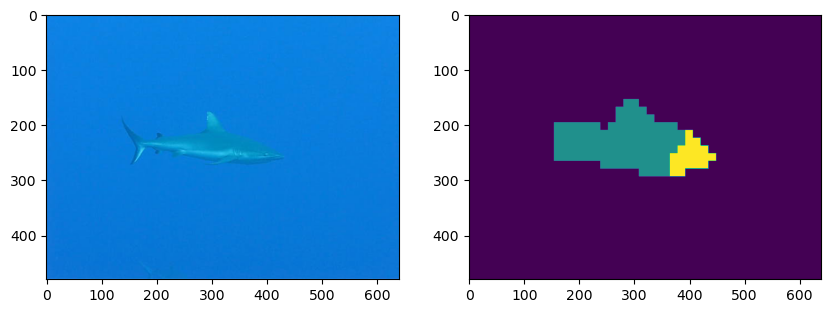

In [54]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
    
ax[0].imshow(img)
ax[1].imshow(pred)

In [55]:
pred_vid = shark_vid.copy()
pred_vid = pred_vid[:40:4]

In [56]:
v2 = napari.view_image(pred_vid)

In [57]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/10 - estimated time left: NA
Predicting image 2/10 - estimated time left: 39.1 seconds
Predicting image 3/10 - estimated time left: 32.7 seconds
Predicting image 4/10 - estimated time left: 28.1 seconds
Predicting image 5/10 - estimated time left: 23.9 seconds
Predicting image 6/10 - estimated time left: 21.1 seconds
Predicting image 7/10 - estimated time left: 18.1 seconds
Predicting image 8/10 - estimated time left: 13.7 seconds
Predicting image 9/10 - estimated time left: 9.1 seconds
Predicting image 10/10 - estimated time left: 4.5 seconds


In [58]:
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x1c8ef2e3af0>